# IRL for PdM
- V.1.0 04-Aug-2024: First version
- V.2.0 07-Aug-2024: New milling env.: Drop Time observation. All force and vibration axes (x, y, z) 

In [2]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
# Custom libraries
from MT_environment import MillingTool_Env
from utilities import downsample, tool_wear_data

In [3]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 1
ADD_NOISE = 0

EPISODES = 4_000
BATCH_SIZE = 16
SAMPLE_DEMONSTRATIONS = 100
EVALUATION_ROUNDS = 20
TENSOR_BOARD = False

PRETRAINED_MODEL = True # If True load model. If False save as model_file 
SAVED_DEMONSTRATIONS = True # If True load saved demonstrations. If False save them
MODEL_FILE = 'Expert_Model_PPO' 
LOG_PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/'
# LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/


- Down-sampling. Input data records: 1000. Sampling rate: 1. Expected rows 1000.    Down-sampled to 1000 rows.


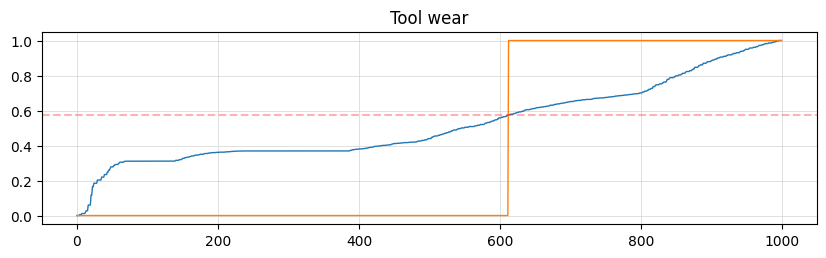

Tool failure RUL threshold at time 950 is 0.050


In [4]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

## 1. Predictive maintenance environment

In [5]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

mt_env = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(mt_env)


 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


In [6]:
mt_env.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 1000


## 2. The "Human" Expert

In [7]:
if TENSOR_BOARD:
    expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
else:
    expert_ppo = PPO('MlpPolicy', env=mt_env)

if not PRETRAINED_MODEL:
    print(f'- Training a *NEW* Expert model...')
    expert_ppo.learn(EPISODES)
    print(f'- Saving Expert model in {MODEL_FILE}')
    expert_ppo.save(MODEL_FILE)
else:
    print(f'- Loading pre-tranined Expert model from {MODEL_FILE}')
    expert_ppo = PPO.load(MODEL_FILE)

- Loading pre-tranined Expert model from Expert_Model_PPO


In [8]:
# if TENSOR_BOARD:
#     expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
# else:
#     expert_a2c = A2C('MlpPolicy', env=mt_env)

# expert_a2c.learn(EPISODES)

In [9]:
reward_ppo, _ = evaluate_policy(expert_ppo, mt_env, 5)
print(f'PPO Expert reward: {reward_ppo:4.2f}')

# reward_a2c, _ = evaluate_policy(expert_a2c, mt_env, 20)
# print(f'A2C Expert reward: {reward_a2c:4.2f}')

PPO Expert reward: 4183.83


## 3. Train the student by applying IRL - using expert demonstrations

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [10]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'records':records, 'rul_threshold':rul_threshold}

mt_venv = make_vec_env(
    'custom/MillingToolEnv-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)


 -- Milling tool environment initiatlized. Potential records 0. RUL threshold 0.000

 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


### Add tool wear data
- IMPORTANT -- note how a vectorized env. methd is called
- NOT like this >>  mt_venv.tool_wear_data(df_train)

In [11]:
# Add tool wear data
# IMPORTANT -- note how a vectorized env. methd is called
# NOT like this >>  mt_venv.tool_wear_data(df_train)
mt_venv.env_method('tool_wear_data', df_train)


 - Milling tool environment: Tool wear data updated: 1000


[None]

In [12]:
# if SAVED_DEMONSTRATIONS:
#     print('Save these demonstrations')
#     serialize.save('Trajectories\', demonstrations)
# else: 
    
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

demonstrations = rollout.flatten_trajectories(rollouts)

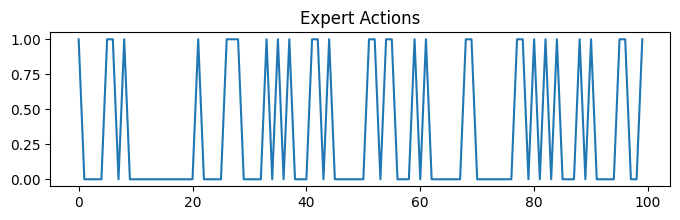

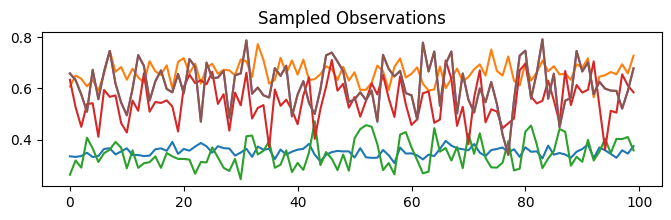

In [13]:
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(demonstrations.acts[n])
    obsvs.append(demonstrations.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

## 3.2 Set up IRL algorithm
- Set up our behavior cloning algorithm
- Compute rewards before showing expert demonstrations

In [14]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu',
        custom_logger = new_logger_irl)
else:
    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu')

In [15]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

Reward before training:  1177.631


## 3.3 Apply IRL - BC algo.
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm- 
Compute reward and compares befor/aftere showing expert demonstrations

In [16]:
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.5      |
|    loss           | 0.693     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 16        |
---------------------------------


486batch [00:02, 229.05batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 77.1      |
|    loss           | 0.617     |
|    neglogp        | 0.618     |
|    prob_true_act  | 0.56      |
|    samples_so_far | 8016      |
---------------------------------


978batch [00:04, 276.04batch/s]

--------------------------------
| batch_size        | 16       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 77.2     |
|    loss           | 0.425    |
|    neglogp        | 0.426    |
|    prob_true_act  | 0.664    |
|    samples_so_far | 16016    |
--------------------------------


1488batch [00:06, 271.48batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000656 |
|    entropy        | 0.656     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.6      |
|    loss           | 0.694     |
|    neglogp        | 0.695     |
|    prob_true_act  | 0.518     |
|    samples_so_far | 24016     |
---------------------------------


1991batch [00:08, 274.68batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -0.000618 |
|    entropy        | 0.618     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.8      |
|    loss           | 0.661     |
|    neglogp        | 0.662     |
|    prob_true_act  | 0.552     |
|    samples_so_far | 32016     |
---------------------------------


2485batch [00:10, 242.91batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -0.000632 |
|    entropy        | 0.632     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.5      |
|    loss           | 0.614     |
|    neglogp        | 0.615     |
|    prob_true_act  | 0.568     |
|    samples_so_far | 40016     |
---------------------------------


2989batch [00:12, 264.37batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -0.000623 |
|    entropy        | 0.623     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.5      |
|    loss           | 0.723     |
|    neglogp        | 0.724     |
|    prob_true_act  | 0.521     |
|    samples_so_far | 48016     |
---------------------------------


3486batch [00:14, 259.24batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.3      |
|    loss           | 0.663     |
|    neglogp        | 0.664     |
|    prob_true_act  | 0.544     |
|    samples_so_far | 56016     |
---------------------------------


3982batch [00:17, 221.66batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -0.000616 |
|    entropy        | 0.616     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.4      |
|    loss           | 0.62      |
|    neglogp        | 0.621     |
|    prob_true_act  | 0.573     |
|    samples_so_far | 64016     |
---------------------------------


4496batch [00:19, 243.29batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 4500      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76        |
|    loss           | 0.493     |
|    neglogp        | 0.494     |
|    prob_true_act  | 0.624     |
|    samples_so_far | 72016     |
---------------------------------


4980batch [00:21, 271.10batch/s]

--------------------------------
| batch_size        | 16       |
| bc/               |          |
|    batch          | 5000     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 76       |
|    loss           | 0.663    |
|    neglogp        | 0.663    |
|    prob_true_act  | 0.55     |
|    samples_so_far | 80016    |
--------------------------------


5495batch [00:23, 218.10batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 5500      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76        |
|    loss           | 0.664     |
|    neglogp        | 0.665     |
|    prob_true_act  | 0.541     |
|    samples_so_far | 88016     |
---------------------------------


5616batch [00:23, 259.85batch/s]
5616batch [00:23, 235.96batch/s]


In [17]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Expert performance:             {reward_ppo:5.3f}')
print(f'Apprentice performance: Before: {reward_before_training:5.3f}')
print(f'                        After:  {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

------------------------------------------------------------------------------------------------------------------------
 **** IRL with Imitation Libraries and Milling environment ****
------------------------------------------------------------------------------------------------------------------------
15-Aug-2024  17:11:17
Episodes: 4000
Expert performance:             4183.825
Apprentice performance: Before: 1177.631
                        After:  4177.448


## Results
```
-------------------------------------------------------------------------------------
| Date-time             | Episodes | Expert   | Apprentice-before |Apprentice-after |
-------------------------------------------------------------------------------------
| 07-Aug-2024  20:51:01 | 4000     | 4176.156 | 147.070           | 4180.070        |
| 07-Aug-2024  21:53:24 |  400     | 4176.033 | 536.258           | 4174.686        |
| 07-Aug-2024  21:53:24 | 4000     | 4176.033 | 536.258           | 4174.686        |
0
```

## 3.3.b Apply IRL - SQIL algo.
- Use expert demonstrations and learn the reward function - using ## 3.3 Apply IRL (BC)
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm
- Compute rewards and compare before/after showing expert demonstrations algorithm
- Compute rewards and compare before/after showing expert demonstrations

In [18]:
# from imitation.algorithms import sqil
# from imitation.util import logger as imit_logger

# if TENSOR_BOARD:
#     # Set new logger
#     tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
#     new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])
    
#     sqil_trainer = sqil.SQIL(   
#         venv = mt_venv,
#         demonstrations = transitions,
#         policy='MlpPolicy',
#         # device='cpu',
#         custom_logger = new_logger_irl
#     )
# else: 
#     sqil_trainer = sqil.SQIL(   
#         venv = mt_venv,
#         demonstrations = demonstrations,
#         policy='MlpPolicy')

In [19]:
# reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

# # Note: set to 1_000_000 to obtain good results
# sqil_trainer.train(total_timesteps = EPISODES)  

# reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

# print(dt_string)
# print(f'Episodes: {EPISODES}')
# print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')

In [20]:
import tempfile
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.policies.serialize import load_policy

with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    print(tmpdir)
    dagger_trainer = SimpleDAggerTrainer(
        venv = mt_venv,
        scratch_dir = tmpdir,
        expert_policy = expert_ppo,
        bc_trainer = bc_trainer,
        rng=rng,
    )
    dagger_trainer.train(EPISODES)

C:\Users\Rajesh\AppData\Local\Temp\dagger_example__tzive76


Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 51.22 examples/s]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000619 |
|    entropy        | 0.619     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.1      |
|    loss           | 0.37      |
|    neglogp        | 0.37      |
|    prob_true_act  | 0.691     |
|    samples_so_far | 16        |
| rollout/          |           |
|    return_max     | 3.02e+03  |
|    return_mean    | 2.93e+03  |
|    return_min     | 2.81e+03  |
|    return_std     | 79.1      |
---------------------------------


142batch [00:25, 17.47batch/s]
323batch [00:26, 101.33batch/s][A
495batch [00:43, 231.69batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.08e-06 |
|    entropy        | 0.00408   |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 85.4      |
|    loss           | 0.000468  |
|    neglogp        | 0.000472  |
|    prob_true_act  | 1         |
|    samples_so_far | 8016      |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.18e+03  |
|    return_min     | 4.16e+03  |
|    return_std     | 12.3      |
---------------------------------


501batch [00:52,  2.76batch/s] 
644batch [00:52, 19.79batch/s]
668batch [00:52, 12.62batch/s]
Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 50.02 examples/s]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.03e-06 |
|    entropy        | 0.00303   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 85.7      |
|    loss           | 0.000334  |
|    neglogp        | 0.000337  |
|    prob_true_act  | 1         |
|    samples_so_far | 16        |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.18e+03  |
|    return_min     | 4.15e+03  |
|    return_std     | 14.6      |
---------------------------------


315batch [00:26, 107.45batch/s]
470batch [00:38, 167.93batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.67e-06 |
|    entropy        | 0.00167   |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 86.4      |
|    loss           | 0.000172  |
|    neglogp        | 0.000173  |
|    prob_true_act  | 1         |
|    samples_so_far | 8016      |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.18e+03  |
|    return_min     | 4.16e+03  |
|    return_std     | 12.6      |
---------------------------------


660batch [00:53, 26.63batch/s] 
992batch [01:08, 234.19batch/s][A

--------------------------------
| batch_size        | 16       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -1.1e-06 |
|    entropy        | 0.0011   |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 86.9     |
|    loss           | 0.000107 |
|    neglogp        | 0.000108 |
|    prob_true_act  | 1        |
|    samples_so_far | 16016    |
| rollout/          |          |
|    return_max     | 4.19e+03 |
|    return_mean    | 4.19e+03 |
|    return_min     | 4.18e+03 |
|    return_std     | 6.86     |
--------------------------------


1001batch [01:21,  2.78batch/s]
1337batch [01:23, 132.21batch/s][A
1352batch [01:23, 16.24batch/s] 


In [21]:
reward_DG, _ = evaluate_policy(dagger_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print("Reward:", reward_DG)

Reward: 4175.545


In [22]:
print(f'Episodes: {EPISODES}')
print(f'Expert performance:             {reward_ppo:5.3f}')
print(f'Apprentice performance - BCO:    Before: {reward_before_training:5.3f}')
print(f'Apprentice performance - BCO:    After:  {reward_after_training:5.3f}')
print(f'Apprentice performance - DAgger: Before: {reward_DG:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

Episodes: 4000
Expert performance:             4183.825
Apprentice performance - BCO:    Before: 1177.631
Apprentice performance - BCO:    After:  4177.448
Apprentice performance - DAgger: Before: 4175.545
